In [1]:
import pandas as pd
import json
import string
import math
import nltk
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#from google.colab import files
#uploaded = files.upload()
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 16.3MB/s 


In [3]:
#Getting the 2% yelp review file (mixed)
link='https://drive.google.com/open?id=1UZrJemORwgEb4mVyVdtkbqOt-VYrgIg7'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_csv_2%.csv')

1UZrJemORwgEb4mVyVdtkbqOt-VYrgIg7


In [4]:
#Getting the 2% yelp review file (mixed) - with equal rating distribution
link='https://drive.google.com/open?id=1rsJIyZ5tggwFDKYqQ_A3sOSDV6cilXRq'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_eq_2%.csv')

1rsJIyZ5tggwFDKYqQ_A3sOSDV6cilXRq


In [5]:
#Getting the 2% food review file
link='https://drive.google.com/open?id=1jZVzy52gDqnPcSmvwfsDJ6GxKOWa6Rgq'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_food_2%.csv')

1jZVzy52gDqnPcSmvwfsDJ6GxKOWa6Rgq


In [6]:
#Getting the 2% food review file - with equal rating distribution
link='https://drive.google.com/open?id=1VepmxxaKAhx6Yl9C66N2xrVM0g38CzJR'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_foodeq_2%.csv')

1VepmxxaKAhx6Yl9C66N2xrVM0g38CzJR


In [7]:
#Getting the yelp business file 2018
link='https://drive.google.com/open?id=1gTdgoZUc4y03im0g6KN41lK672alKKvi'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('yelp_business.csv')

1gTdgoZUc4y03im0g6KN41lK672alKKvi


In [0]:
#Reading the review file to panda
yelp_2_review_data = pd.read_csv('review_csv_2%.csv', sep=",", index_col=0)
yelp_2_review_data = yelp_2_review_data.reset_index(drop=True) #re-indexing
yelp_2_review_data.sample(n=5)    # Randomly select n=5 rows and return them
yelp_2_review_data = yelp_2_review_data.head(n=10000) 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


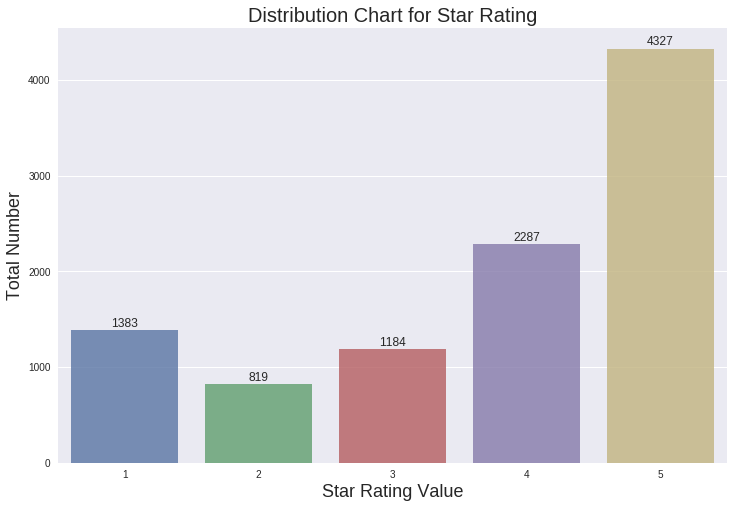

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# checking the Star rating distribution of dataset

dist = yelp_2_review_data['stars'].value_counts()
dist = dist.sort_index()

# Plotting the Distribution
plt.figure(figsize=(12,8))
ax = sns.barplot(dist.index, dist.values, alpha=0.8)
plt.title("Distribution Chart for Star Rating", fontsize=20)
plt.ylabel("Total Number", fontsize=18)
plt.xlabel("Star Rating Value", fontsize=18)

rects = ax.patches
labels = dist.values
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

In [10]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
yelp_2_review_data['length'] = yelp_2_review_data['text'].apply(len)
yelp_2_review_data.head(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,categories,length
0,i8RhpEgalkeY97p0YQ0JeA,OzGlDEQ_vzH8QU9NBRs-pw,HxLouUPqiou7D6YK5t-DgQ,3,2011-03-06,"Pretty good, but it'll cost ya.\r\n\r\nThe Fre...",1,0,1,wine bars tapas bars canadian new bars night...,765
1,RH_VhBzxegIWT_crf9ButA,lxt4LomsbAjBvk5POhDTEw,giptYxR9l72ogEKaxqch4A,4,2011-05-30,Boyfriend had planned to pick up some sort of ...,8,6,6,food beer wine spirits,708


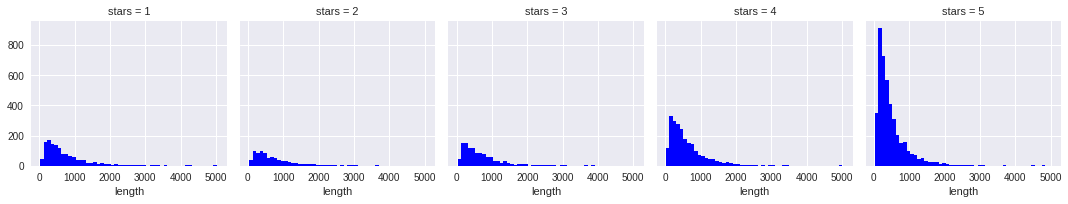

In [11]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=yelp_2_review_data,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [12]:
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = yelp_2_review_data.groupby('stars').mean()
stval

,useful,funny,cool,length
stars,,,,
1,2.109183,0.662328,0.238612,774.942878
2,1.603175,0.623932,0.344322,748.324786
3,1.366554,0.593750,0.628378,709.352196
4,1.359860,0.519895,0.803673,632.951902
5,1.120407,0.354287,0.584007,494.417841


In [13]:
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval.corr()

,useful,funny,cool,length
useful,1.000000,0.814664,-0.786690,0.818531
funny,0.814664,1.000000,-0.551165,0.997954
cool,-0.786690,-0.551165,1.000000,-0.593092
length,0.818531,0.997954,-0.593092,1.000000


In [0]:
df=yelp_2_review_data.copy()

# Convert text to lowercase
df.loc[:,'text'] = df['text'].str.lower()

# Remove punctuation
df ['text']= df ['text'].str.replace('[^a-zA-Z]', ' ')

**Stem and remove stop words**

In [0]:
# Create the lemmatizer and the different stemmers
snowball = SnowballStemmer("english")
porter = PorterStemmer()
lancaster=LancasterStemmer()
lemmatizer = WordNetLemmatizer()

**Define the 7 different tokenizing function for the TFIDFVectorizer **

In [0]:
# Porter Stemmer tokens ---------------------------------------------
def portertokens(x):
    x = x.split()
    stems = []
    [stems.append(porter.stem(word)) for word in x]
    return stems

In [0]:
# Snowball Stemmer tokens ---------------------------------------------
def snowballtokens(x):
    x = x.split()
    stems = []
    [stems.append(snowball.stem(word)) for word in x]
    return stems

In [0]:
# Lancaster Stemmer tokens ---------------------------------------------
def lancastertokens(x):
    x = x.split()
    stems = []
    [stems.append(lancaster.stem(word)) for word in x]
    return stems

In [0]:
# Lemmetization tokens ---------------------------------------------
def lemmatizertokens(x):
    x = x.split()
    stems = []
    [stems.append(lemmatizer.lemmatize(word,pos="a")) for word in x]
    return stems

In [0]:
# Porter Stemmer & Lemmitization tokens ------------------------------------
def portlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(porter.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

In [0]:
# Snowball Stemmer & Lemmitization tokens ----------------------------------
def snowlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(snowball.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

In [0]:
# Lancaster Stemmer & Lemmitization tokens ----------------------------------
def lanlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(lancaster.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

**Develop features array**

In [23]:
# Define the vectorizer
vectorizer = TfidfVectorizer(tokenizer = portlemtokens, stop_words = 'english', ngram_range=(1,2), max_features=None,  min_df = 0.01)

# Fit the vectorizers to the data
feature_words = vectorizer.fit_transform(df['text'])

features = pd.DataFrame(feature_words.toarray(), columns = vectorizer.get_feature_names())
features = pd.concat([features, df[['stars']]], axis = 1)
features.sample(n=5)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

,abl,abov,absolut,accommod,actual,ad,add,addit,afford,afternoon,...,write,wrong,ye,year,year ago,yelp,young,yum,yummi,stars
1621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
6886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [24]:
print("Number of NaN in Features=",features.isnull().sum().sum())

Number of NaN in Features= 0


In [0]:
# # CLASSIFICATION WITH ALL 5 STAR CLASSES
# x = features.copy()
# y=x.loc[:,'stars']
# print(x.shape)

# from sklearn.model_selection import train_test_split, cross_val_score
# # SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify= x['stars'],random_state=101)

# #Dropping the stars from the x features
# x_train=x_train.drop(columns=['stars'])
# x_test=x_test.drop(columns=['stars'])

In [26]:
# CLASSIFICATION AS KAGGLE EXAMPLE WITH ONLY 3 CLASSES
x = features[(features['stars']==1) | (features['stars']==3) | (features['stars']==5)]
y=x.loc[:,'stars']
print(x.shape)


from sklearn.model_selection import train_test_split, cross_val_score
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify= x['stars'],random_state=101)

#Seperating the stars
y_train=x_train.loc[:,'stars']
y_test=x_test.loc[:,'stars']

#Dropping the stars from the x features
x_train=x_train.drop(columns=['stars'])
x_test=x_test.drop(columns=['stars'])

(6894, 926)


In [0]:
%timeit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)
import numpy as np

# Random Forest
#With Hyper Parameters Tuning
model=RandomForestClassifier(random_state=56)

#hyper parameters set
params = {'criterion':['gini','entropy'],
          'max_depth': [3, 5,8,10,None],
          'n_estimators':[10,15,20,25,100],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[2,3,4], 
          'random_state':[56],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=-1,cv=folds,iid=False)
model1.fit(x_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters for Random Forest:\n",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
#Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))

Best Hyper Parameters for Random Forest:
 {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 56}
Best Parameters Score:
 0.7884033920446963
Confusion Matrix for Random Forest Classifier:
[[ 277   18  120]
 [  46   95  214]
 [  22    3 1274]]
Score: 79.56
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.67      0.73       415
           3       0.82      0.27      0.40       355
           5       0.79      0.98      0.88      1299

   micro avg       0.80      0.80      0.80      2069
   macro avg       0.80      0.64      0.67      2069
weighted avg       0.80      0.80      0.77      2069



In [0]:
%timeit
#LinearSVM
#With Hyper Parameters Tuning
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

#making the instance
model=svm.SVC(random_state=12)
#Hyper Parameters Set
params = {'C': [6,7,8,9,10,11,12], 
          'kernel': ['linear']}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=-1,cv=folds,iid=False)
#Learning
model1.fit(x_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters for Linear SVM:\n",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
#Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for Linear SVM:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Hyper Parameters for Linear SVM:
 {'C': 6, 'kernel': 'linear'}
Best Parameters Score:
 0.8037514500286239
Confusion Matrix for Linear SVM:
[[ 313   56   46]
 [  65  188  102]
 [  38   62 1199]]
Score: 82.17
Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.75      0.75       415
           3       0.61      0.53      0.57       355
           5       0.89      0.92      0.91      1299

   micro avg       0.82      0.82      0.82      2069
   macro avg       0.75      0.74      0.74      2069
weighted avg       0.82      0.82      0.82      2069



In [0]:
#RBF SVM
#With Hyper Parameters Tuning
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

#making the instance
model=svm.SVC(random_state=12)
#Hyper Parameters Set
params = {'C': [6,15,30, 50], 
          'gamma': [0.01,0.1, 1, 10],
          'kernel': ['rbf'], 'class_weight':['balanced']}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=folds,iid=False)
#Learning
model1.fit(x_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters for RBF SVM:\n",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
#Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for RBF SVM:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Hyper Parameters for RBF SVM:
 {'C': 30, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Best Parameters Score:
 0.8383563320248102
Confusion Matrix for RBF SVM:
[[ 309   45   61]
 [  41  193  121]
 [  26   42 1231]]
Score: 83.76
Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.74      0.78       415
           3       0.69      0.54      0.61       355
           5       0.87      0.95      0.91      1299

   micro avg       0.84      0.84      0.84      2069
   macro avg       0.79      0.75      0.77      2069
weighted avg       0.83      0.84      0.83      2069



In [0]:
 %%timeit

#kNearestNeighbors
#With Hyper Parameters Tuning
#importing modules
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

#making the instance
model = KNeighborsClassifier(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':[11,13,15],
          'leaf_size':[1,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto','ball_tree'],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=1,cv=folds,iid=False)
#Learning
model1.fit(x_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters for KNN:\n",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
# Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for KNN:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))

In [0]:
# XGBoost Classifier
import xgboost

# # Gradient Boosting Classifier Parameter Evaluation
#With Hyper Parameters Tuning
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

model = XGBClassifier(n_estimators=100,nthread=1)

params = {'min_child_weight': [1,3],
        'gamma': [0.5, 1, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5,1],
        'max_depth': [3,6,9]}

model1 = GridSearchCV(model, param_grid=params, n_jobs=-1,cv=5,iid=False)
#Learning
model1.fit(x_train, y_train)
#The best hyper parameters is set
print("Best Hyper Parameters for XGBoost:",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
#Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))


Best Hyper Parameters for XGBoost: {'colsample_bytree': 1, 'gamma': 1, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6}
Best Parameters Score:
 0.8163817651122512
Confusion Matrix for XGBoost:
[[ 315   33   67]
 [  41  175  139]
 [  37   34 1228]]
Score: 83.04
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.76      0.78       415
           3       0.72      0.49      0.59       355
           5       0.86      0.95      0.90      1299

   micro avg       0.83      0.83      0.83      2069
   macro avg       0.79      0.73      0.75      2069
weighted avg       0.82      0.83      0.82      2069



In [0]:
# # Multinomial Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# mnb = MultinomialNB()
# mnb.fit(x_train,y_train)
# predmnb = mnb.predict(x_test)
# print("Confusion Matrix for Multinomial Naive Bayes:")
# print(confusion_matrix(y_test,predmnb))
# print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,predmnb))

In [0]:
# Decision Tree
#With Hyper Parameters Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

#making the instance
model= DecisionTreeClassifier()
#Hyper Parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2',None],
          'min_samples_split': [2,4,5], 
          'min_samples_leaf':[3,5,7,9,10],
          'random_state':[10]}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=-1,cv=folds,iid=False)
#Learning
model1.fit(x_train, y_train)
#The best hyper parameters is set
print("Best Hyper Parameters for Decision Trees:",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
#Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))

Best Hyper Parameters for Decision Trees: {'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 10}
Best Parameters Score:
 0.699706505059766
Confusion Matrix for Decision Tree:
[[ 253   60  102]
 [  76  114  165]
 [ 113  115 1071]]
Score: 69.5
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.61      0.59       415
           3       0.39      0.32      0.35       355
           5       0.80      0.82      0.81      1299

   micro avg       0.70      0.70      0.70      2069
   macro avg       0.59      0.59      0.59      2069
weighted avg       0.69      0.70      0.69      2069



In [0]:
# MULTILAYER PERCEPTRON CLASSIFIER
#With Hyper Parameters Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

#making the instance
model=  MLPClassifier()
#Hyper Parameters Set
params = {'solver': ['lbfgs'], 
          'max_iter': [50,200,400],  
          'hidden_layer_sizes':[(100,),(200,100),(200,200)], 
          'random_state':[23],
          'activation': ['identity', 'logistic', 'tanh', 'relu']}

#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=-1,cv=5,iid=False)
#Learning
model1.fit(x_train, y_train)
#The best hyper parameters is set
print("Best Hyper Parameters for MultiLayer Perceptron:",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
#Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for MLP:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Hyper Parameters for MultiLayer Perceptron: {'activation': 'relu', 'hidden_layer_sizes': (200, 200), 'max_iter': 50, 'random_state': 23, 'solver': 'lbfgs'}
Best Parameters Score:
 0.8311041244266782
Confusion Matrix for MLP:
[[ 338   40   37]
 [  56  219   80]
 [  31  103 1165]]
Score: 83.23
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.81      0.80       415
           3       0.60      0.62      0.61       355
           5       0.91      0.90      0.90      1299

   micro avg       0.83      0.83      0.83      2069
   macro avg       0.77      0.78      0.77      2069
weighted avg       0.83      0.83      0.83      2069



In [0]:
# # Gradient Boosting Classifier Parameter Evaluation
#With Hyper Parameters Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

model = GradientBoostingClassifier(random_state=0)
#Hyper Parameters Set
params = {'learning_rate': [0.05, 0.1,0.5],
    'max_features': [0.5, 1],
    'max_depth': [3,5,7]}

model1 = GridSearchCV(model, param_grid=params, n_jobs=-1,cv=folds,iid=False)
#Learning
model1.fit(x_train, y_train)
#The best hyper parameters is set
print("Best Hyper Parameters for GradientBoost:",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
#Prediction
prediction=model1.predict(x_test)
print("Confusion Matrix for GradientBoost:")
print(confusion_matrix(y_test,prediction))
print("Score:",round(accuracy_score(y_test,prediction)*100,2))
print("Classification Report:")
print(classification_report(y_test,prediction))

Best Hyper Parameters for GradientBoost: {'learning_rate': 0.5, 'max_depth': 3, 'max_features': 0.5}
Best Parameters Score:
 0.8109831651407738
Confusion Matrix for GradientBoost:
[[ 284   53   78]
 [  46  180  129]
 [  32   51 1216]]
Score: 81.2
Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.68      0.73       415
           3       0.63      0.51      0.56       355
           5       0.85      0.94      0.89      1299

   micro avg       0.81      0.81      0.81      2069
   macro avg       0.76      0.71      0.73      2069
weighted avg       0.80      0.81      0.80      2069

